**Without Refractive index as Feature**

⏳ Downloading data from Materials Project...


Retrieving SummaryDoc documents:   0%|          | 0/12729 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/3029 [00:00<?, ?it/s]

ValenceOrbital:   0%|          | 0/3029 [00:00<?, ?it/s]

🧹 Dropped 0 rows due to NaNs after featurization.
📊 Model Performance:
XGBoost -> R²: 0.8600, RMSE: 0.5528 eV
Random Forest -> R²: 0.8452, RMSE: 0.5814 eV
Gradient Boosting -> R²: 0.8588, RMSE: 0.5553 eV
Ridge Regression -> R²: 0.6914, RMSE: 0.8209 eV
Linear Regression -> R²: 0.6958, RMSE: 0.8150 eV
SVR -> R²: 0.7677, RMSE: 0.7123 eV
ElasticNet -> R²: 0.1324, RMSE: 1.3764 eV
KNN -> R²: 0.3726, RMSE: 1.1705 eV
AdaBoost -> R²: 0.6050, RMSE: 0.9288 eV
Decision Tree -> R²: 0.6563, RMSE: 0.8663 eV
MLP Regressor -> R²: 0.7847, RMSE: 0.6857 eV
Stacked Trees -> R²: 0.8327, RMSE: 0.6045 eV


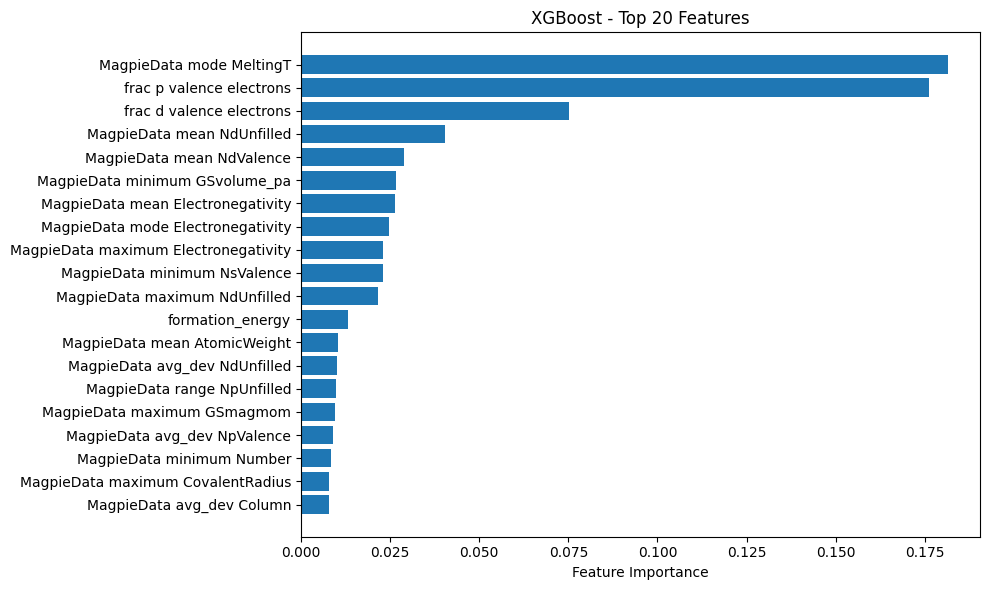

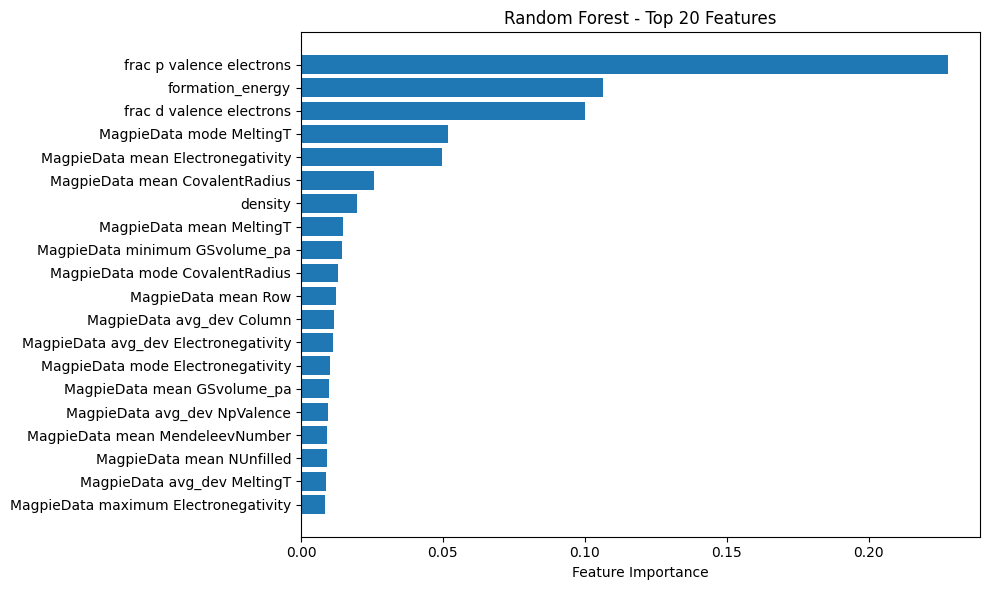

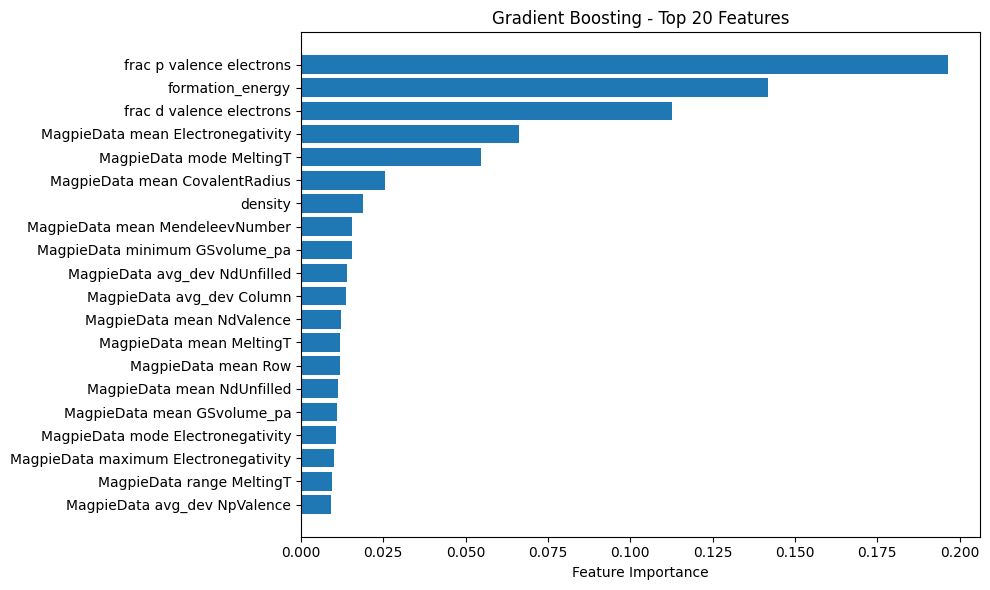

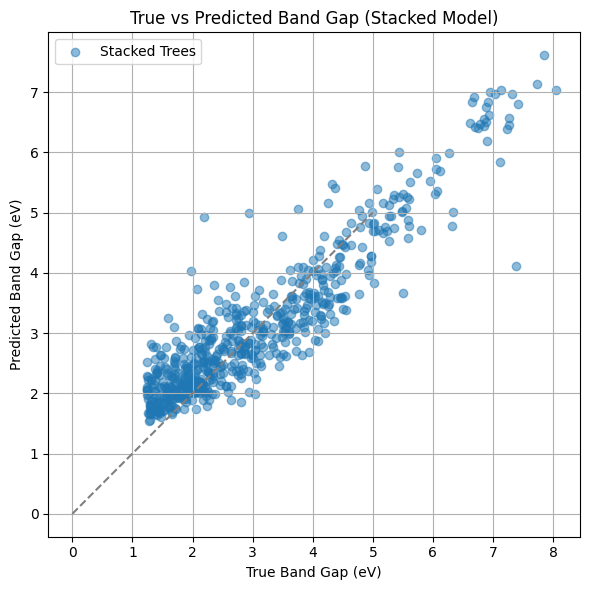


📋 Model Comparison Table:
                         R2      RMSE
XGBoost            0.860049  0.552831
Gradient Boosting  0.858811  0.555271
Random Forest      0.845187  0.581445
Stacked Trees      0.832680  0.604474
MLP Regressor      0.784691  0.685702
SVR                0.767661  0.712305
Linear Regression  0.695825  0.815016
Ridge Regression   0.691432  0.820881
Decision Tree      0.656334  0.866309
AdaBoost           0.604996  0.928764
KNN                0.372603  1.170511
ElasticNet         0.132434  1.376435
✅ Saved test predictions to 'band_gap_predictions.csv'


In [ ]:
# STEP 1: Install Libraries
!pip install -q mp-api matminer scikit-learn xgboost pandas matplotlib

# STEP 2: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from mp_api.client import MPRester
from matminer.featurizers.composition import ElementProperty, ValenceOrbital, IonProperty, Stoichiometry, AtomicOrbitals
from pymatgen.core.composition import Composition
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

# STEP 3: API Key and File
api_key = "4UYtqqzTZo6QAKoDKBdu0hDtYAuyWYXL"
csv_file = "dataset_1.csv"

# STEP 4: Download or Load Dataset
if not os.path.exists(csv_file):
    print("⏳ Downloading data from Materials Project...")
    with MPRester(api_key) as mpr:
        docs = mpr.materials.summary.search(
            band_gap=(1.23, None),
            is_stable=True,
            fields=[
                "material_id", "formula_pretty", "band_gap",
                "is_metal", "is_gap_direct", "density", "volume",
                "formation_energy_per_atom", "energy_above_hull","n"
            ]
        )
    data = []
    for doc in docs:
        data.append({
            "material_id": doc.material_id,
            "formula": doc.formula_pretty,
            "band_gap": doc.band_gap,
            "is_metal": doc.is_metal,
            "is_gap_direct": doc.is_gap_direct,
            "density": doc.density,
            "volume": doc.volume,
            "formation_energy": doc.formation_energy_per_atom,
            "energy_above_hull": getattr(doc, "energy_above_hull", 0.0),
            "refractive_index": doc.n

        })
    df = pd.DataFrame(data)
    df.to_csv(csv_file, index=False)
else:
    print("✅ Loading from cache...")
    df = pd.read_csv(csv_file)

# STEP 5: Clean and Featurize
df.dropna(inplace=True)
df["composition"] = df["formula"].apply(Composition)

# Featurize with Magpie + others
df = ElementProperty.from_preset("magpie").featurize_dataframe(df, "composition", ignore_errors=True)
df = ValenceOrbital().featurize_dataframe(df, "composition", ignore_errors=True)
# df = IonProperty().featurize_dataframe(df, "composition", ignore_errors=True)
# df = Stoichiometry().featurize_dataframe(df, "composition", ignore_errors=True)
# df = AtomicOrbitals().featurize_dataframe(df, "composition", ignore_errors=True)

# STEP 6: Additional Feature Engineering + Clean NaNs
df["normalized_density"] = df["density"] / df["volume"]
before = len(df)
df.dropna(inplace=True)
after = len(df)
print(f"🧹 Dropped {before - after} rows due to NaNs after featurization.")

# STEP 7: Prepare Features and Labels
drop_cols = ["material_id", "formula", "band_gap", "composition","refractive_index"]
X = df.drop(columns=drop_cols).select_dtypes(include=[np.number])
y = df["band_gap"]

# Save identifiers for prediction export
test_identifiers = df[["material_id", "formula"]]

# STEP 8: Split Data
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X, y, test_identifiers, test_size=0.2, random_state=42
)

# STEP 9: Scale Data
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# STEP 10: Tree models use unscaled
X_train_tree = X_train.values
X_test_tree = X_test.values

# STEP 11: Models
models = {
    "XGBoost": XGBRegressor(n_estimators=600, learning_rate=0.03, max_depth=8, random_state=42, n_jobs=-1),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=400, learning_rate=0.03, max_depth=5, random_state=42),
    "Ridge Regression": Ridge(alpha=1.0, random_state=42),
    "Linear Regression": LinearRegression(),
    "SVR": SVR(kernel='rbf', C=10, gamma='scale'),
    "ElasticNet": ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "AdaBoost": AdaBoostRegressor(n_estimators=200, random_state=42),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "MLP Regressor": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

# STEP 12: Train + Evaluate
results = {}
print("📊 Model Performance:")
for name, model in models.items():
    if name in ["Ridge Regression", "Linear Regression", "SVR", "ElasticNet", "MLP Regressor"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train_tree, y_train)
        y_pred = model.predict(X_test_tree)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = (r2, rmse, y_pred, model)
    print(f"{name} -> R²: {r2:.4f}, RMSE: {rmse:.4f} eV")

# STEP 13: Stacked Tree Models
tree_models = ["XGBoost", "Random Forest", "Gradient Boosting", "AdaBoost", "Decision Tree"]
stacked_pred = np.mean([results[m][2] for m in tree_models], axis=0)
r2_stack = r2_score(y_test, stacked_pred)
rmse_stack = np.sqrt(mean_squared_error(y_test, stacked_pred))
print(f"Stacked Trees -> R²: {r2_stack:.4f}, RMSE: {rmse_stack:.4f} eV")

# STEP 14: Feature Importance (Top Models)
def plot_importance(model, model_name):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:20]
        features = X.columns[indices]
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(indices)), importances[indices][::-1], align="center")
        plt.yticks(range(len(indices)), features[::-1])
        plt.xlabel("Feature Importance")
        plt.title(f"{model_name} - Top 20 Features")
        plt.tight_layout()
        plt.show()

for model_name in ["XGBoost", "Random Forest", "Gradient Boosting"]:
    plot_importance(results[model_name][3], model_name)

# STEP 15: Plot True vs Predicted (Stacked)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, stacked_pred, alpha=0.5, label="Stacked Trees")
plt.plot([0, 5], [0, 5], '--', color='gray')
plt.xlabel("True Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.title("True vs Predicted Band Gap (Stacked Model)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# STEP 16: Results Summary Table
results_df = pd.DataFrame({name: {"R2": r[0], "RMSE": r[1]} for name, r in results.items()}).T
results_df.loc["Stacked Trees"] = {"R2": r2_stack, "RMSE": rmse_stack}
print("\n📋 Model Comparison Table:")
print(results_df.sort_values("R2", ascending=False))

# STEP 17: Save CSV of Predictions
prediction_df = id_test.copy()
prediction_df["True Band Gap (eV)"] = y_test.values
prediction_df["Predicted Band Gap (eV)"] = stacked_pred
prediction_df.to_csv("band_gap_predictions_1.csv", index=False)
print("✅ Saved test predictions to 'band_gap_predictions.csv'")

With Refractive index as Feature

⏳ Downloading data from Materials Project...


Retrieving SummaryDoc documents:   0%|          | 0/12729 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/3029 [00:00<?, ?it/s]

ValenceOrbital:   0%|          | 0/3029 [00:00<?, ?it/s]

🧹 Dropped 0 rows due to NaNs after featurization.
📊 Model Performance:
XGBoost -> R²: 0.8811, RMSE: 0.5213 eV
Random Forest -> R²: 0.8620, RMSE: 0.5617 eV
Gradient Boosting -> R²: 0.8827, RMSE: 0.5178 eV
Ridge Regression -> R²: 0.7235, RMSE: 0.7951 eV
Linear Regression -> R²: 0.7237, RMSE: 0.7948 eV
SVR -> R²: 0.8010, RMSE: 0.6745 eV
ElasticNet -> R²: 0.1679, RMSE: 1.3793 eV
KNN -> R²: 0.3734, RMSE: 1.1969 eV
AdaBoost -> R²: 0.6758, RMSE: 0.8609 eV
Decision Tree -> R²: 0.7250, RMSE: 0.7930 eV
MLP Regressor -> R²: 0.8446, RMSE: 0.5960 eV
Stacked Trees -> R²: 0.8570, RMSE: 0.5718 eV


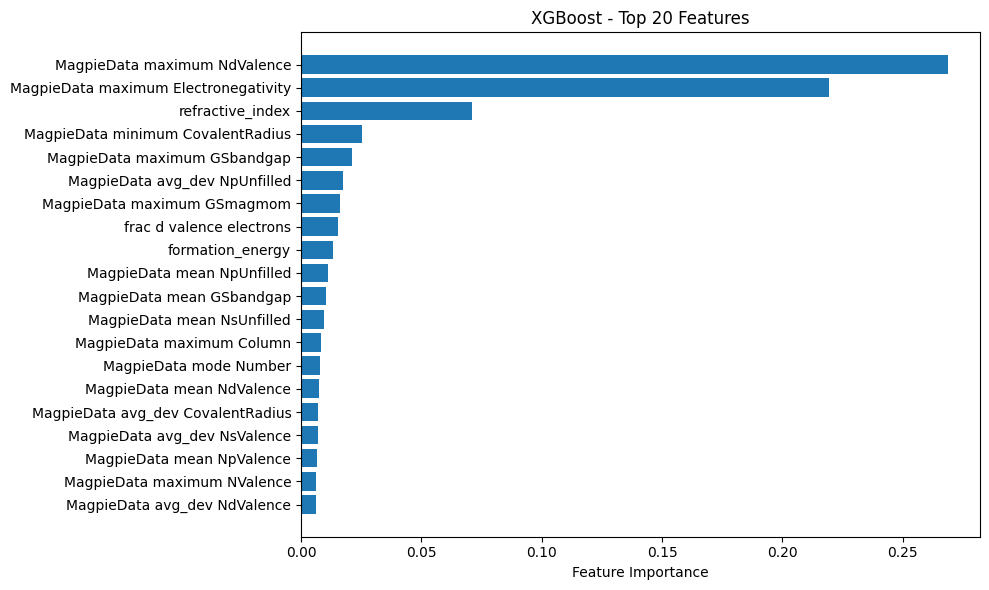

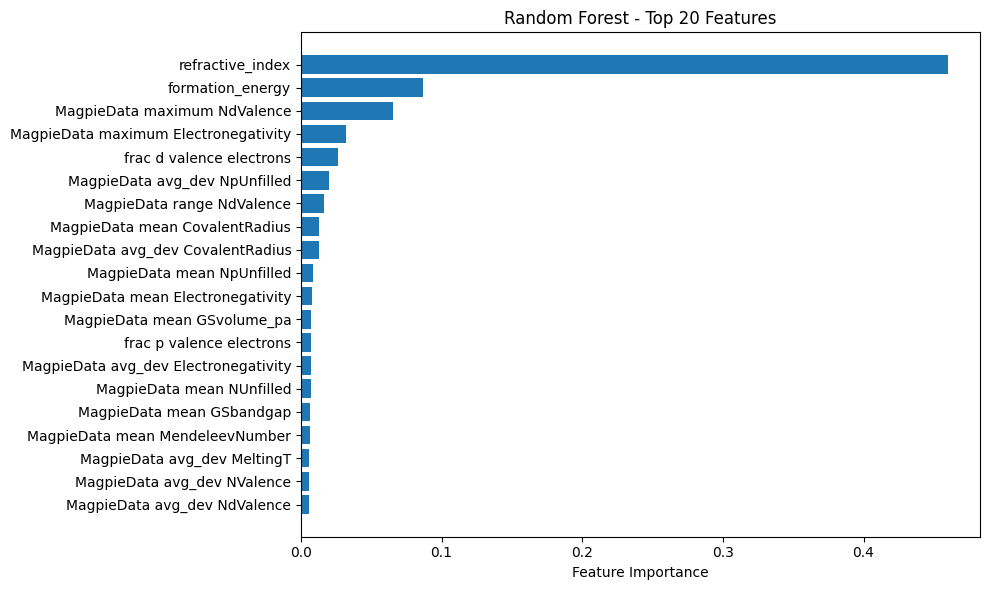

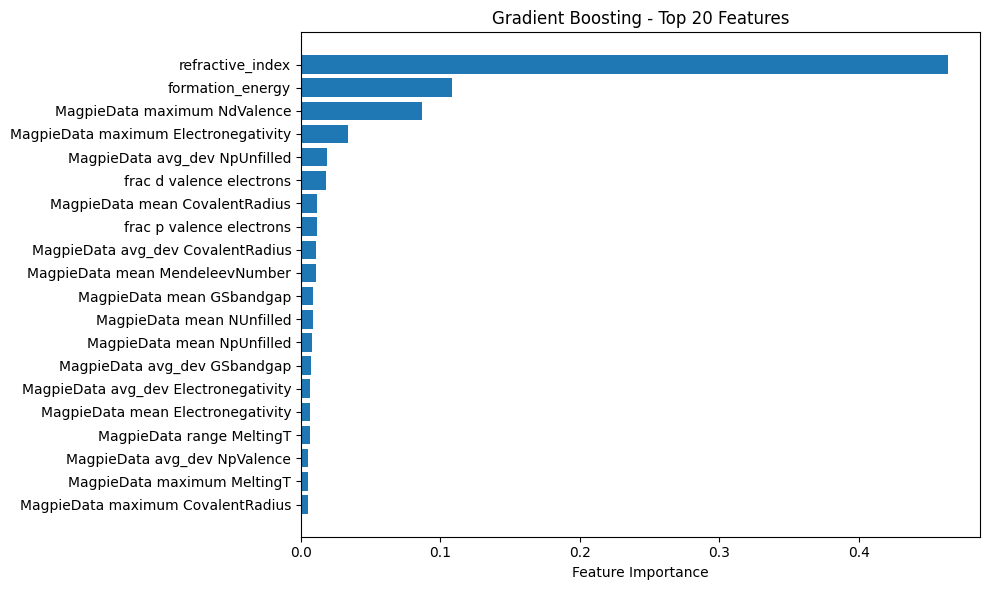

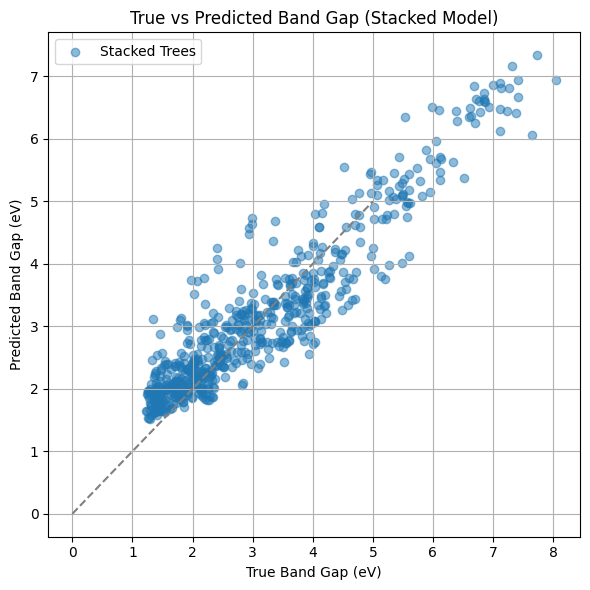


📋 Model Comparison Table:
                         R2      RMSE
Gradient Boosting  0.882699  0.517848
XGBoost            0.881112  0.521339
Random Forest      0.861982  0.561719
Stacked Trees      0.857006  0.571756
MLP Regressor      0.844637  0.595970
SVR                0.800996  0.674501
Decision Tree      0.724951  0.792970
Linear Regression  0.723707  0.794761
Ridge Regression   0.723487  0.795077
AdaBoost           0.675796  0.860916
KNN                0.373395  1.196874
ElasticNet         0.167871  1.379262
✅ Saved test predictions to 'band_gap_predictions.csv'


In [ ]:
# STEP 1: Install Libraries
!pip install -q mp-api matminer scikit-learn xgboost pandas matplotlib

# STEP 2: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from mp_api.client import MPRester
from matminer.featurizers.composition import ElementProperty, ValenceOrbital, IonProperty, Stoichiometry, AtomicOrbitals
from pymatgen.core.composition import Composition
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

# STEP 3: API Key and File
api_key = "4UYtqqzTZo6QAKoDKBdu0hDtYAuyWYXL"
csv_file = "dataset_2.csv"

# STEP 4: Download or Load Dataset
if not os.path.exists(csv_file):
    print("⏳ Downloading data from Materials Project...")
    with MPRester(api_key) as mpr:
        docs = mpr.materials.summary.search(
            band_gap=(1.23, None),
            is_stable=True,
            fields=[
                "material_id", "formula_pretty", "band_gap",
                "is_metal", "is_gap_direct", "density", "volume",
                "formation_energy_per_atom", "energy_above_hull", "n"
            ]
        )
    data = []
    for doc in docs:
        data.append({
            "material_id": doc.material_id,
            "formula": doc.formula_pretty,
            "band_gap": doc.band_gap,
            "is_metal": doc.is_metal,
            "is_gap_direct": doc.is_gap_direct,
            "density": doc.density,
            "volume": doc.volume,
            "formation_energy": doc.formation_energy_per_atom,
            "energy_above_hull": getattr(doc, "energy_above_hull", 0.0),
            "refractive_index": doc.n
        })
    df = pd.DataFrame(data)
    df.to_csv(csv_file, index=False)
else:
    print("✅ Loading from cache...")
    df = pd.read_csv(csv_file)

# STEP 5: Clean and Featurize
df.dropna(inplace=True)
df["composition"] = df["formula"].apply(Composition)

# Featurize with Magpie + others
df = ElementProperty.from_preset("magpie").featurize_dataframe(df, "composition", ignore_errors=True)
df = ValenceOrbital().featurize_dataframe(df, "composition", ignore_errors=True)
# df = IonProperty().featurize_dataframe(df, "composition", ignore_errors=True)
# df = Stoichiometry().featurize_dataframe(df, "composition", ignore_errors=True)
# df = AtomicOrbitals().featurize_dataframe(df, "composition", ignore_errors=True)

# STEP 6: Additional Feature Engineering + Clean NaNs
df["normalized_density"] = df["density"] / df["volume"]
before = len(df)
df.dropna(inplace=True)
after = len(df)
print(f"🧹 Dropped {before - after} rows due to NaNs after featurization.")

# STEP 7: Prepare Features and Labels
drop_cols = ["material_id", "formula", "band_gap", "composition"]
X = df.drop(columns=drop_cols).select_dtypes(include=[np.number])
y = df["band_gap"]

# Save identifiers for prediction export
test_identifiers = df[["material_id", "formula"]]

# STEP 8: Split Data
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X, y, test_identifiers, test_size=0.2, random_state=42
)

# STEP 9: Scale Data
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# STEP 10: Tree models use unscaled
X_train_tree = X_train.values
X_test_tree = X_test.values

# STEP 11: Models
models = {
    "XGBoost": XGBRegressor(n_estimators=600, learning_rate=0.03, max_depth=8, random_state=42, n_jobs=-1),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=400, learning_rate=0.03, max_depth=5, random_state=42),
    "Ridge Regression": Ridge(alpha=1.0, random_state=42),
    "Linear Regression": LinearRegression(),
    "SVR": SVR(kernel='rbf', C=10, gamma='scale'),
    "ElasticNet": ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "AdaBoost": AdaBoostRegressor(n_estimators=200, random_state=42),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "MLP Regressor": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

# STEP 12: Train + Evaluate
results = {}
print("📊 Model Performance:")
for name, model in models.items():
    if name in ["Ridge Regression", "Linear Regression", "SVR", "ElasticNet", "MLP Regressor"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train_tree, y_train)
        y_pred = model.predict(X_test_tree)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = (r2, rmse, y_pred, model)
    print(f"{name} -> R²: {r2:.4f}, RMSE: {rmse:.4f} eV")

# STEP 13: Stacked Tree Models
tree_models = ["XGBoost", "Random Forest", "Gradient Boosting", "AdaBoost", "Decision Tree"]
stacked_pred = np.mean([results[m][2] for m in tree_models], axis=0)
r2_stack = r2_score(y_test, stacked_pred)
rmse_stack = np.sqrt(mean_squared_error(y_test, stacked_pred))
print(f"Stacked Trees -> R²: {r2_stack:.4f}, RMSE: {rmse_stack:.4f} eV")

# STEP 14: Feature Importance (Top Models)
def plot_importance(model, model_name):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:20]
        features = X.columns[indices]
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(indices)), importances[indices][::-1], align="center")
        plt.yticks(range(len(indices)), features[::-1])
        plt.xlabel("Feature Importance")
        plt.title(f"{model_name} - Top 20 Features")
        plt.tight_layout()
        plt.show()

for model_name in ["XGBoost", "Random Forest", "Gradient Boosting"]:
    plot_importance(results[model_name][3], model_name)

# STEP 15: Plot True vs Predicted (Stacked)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, stacked_pred, alpha=0.5, label="Stacked Trees")
plt.plot([0, 5], [0, 5], '--', color='gray')
plt.xlabel("True Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.title("True vs Predicted Band Gap (Stacked Model)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# STEP 16: Results Summary Table
results_df = pd.DataFrame({name: {"R2": r[0], "RMSE": r[1]} for name, r in results.items()}).T
results_df.loc["Stacked Trees"] = {"R2": r2_stack, "RMSE": rmse_stack}
print("\n📋 Model Comparison Table:")
print(results_df.sort_values("R2", ascending=False))

# STEP 17: Save CSV of Predictions
prediction_df = id_test.copy()
prediction_df["True Band Gap (eV)"] = y_test.values
prediction_df["Predicted Band Gap (eV)"] = stacked_pred
prediction_df.to_csv("band_gap_predictions_2.csv", index=False)
print("✅ Saved test predictions to 'band_gap_predictions.csv'")